# Airport Reliability Dashboard
Filter & Fly has had problems with airports and airlines constantly being delayed or cancelled. This leads to frustrations with their customers who demand a refund for their trip. They have tasked us with creating a dashboard to identify airport and airline risks in order to reduce customer frustration and avoid rebooking/refund costs.

## Key questions include:
* Which airlines have the lowest likelihood of delay, and which airports are consistently most on-time?
* How do delay rates and average delay minutes change by season or month?
* What are the most common causes (carrier, weather, airport) for specific airline–airport combinations?
* Correlation with airlines and airports?
* Ranking reliability on the dashboard (low risk or high risk filters)?
* Risk by state/location and by season?

* Using these insights, the agency can recommend lower-risk routes, suggest better departure seasons, and flag high-risk itineraries that may need extra buffer time or backup options. To clarify, **we are not forecasting** but providing information to help the travel agency make informed business decisions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

## Loading the Data
* year: The calendar year of the recorded flight operations.
* month: The month (1–12) corresponding to the data entry.
* carrier: The airline’s IATA carrier code (e.g., “9E”).
* carrier_name: Full official name of the airline (e.g., “Endeavor Air Inc.”).
* airport: The IATA airport code of the origin airport (e.g., “ABE”).
* airport_name: Full name of the origin airport, including city and state.
* arr_flights: Total number of arrival flights operated in that month for the given airline–airport pair.
* arr_del15: Number of arrival flights delayed by 15 minutes or more (DOT standard definition of a delay).
* carrier_ct: Count of flights delayed due to airline-related issues (e.g., crew delays, maintenance, equipment problems).
* weather_ct: Count of flights delayed because of significant weather conditions.
* nas_ct: Count of flights delayed due to National Airspace System issues (e.g., air traffic control, heavy traffic volume, system capacity).
* security_ct: Count of flights delayed due to security-related factors (e.g., screening issues, security breaches).
* late_aircraft_ct: Count of flights delayed because the aircraft arrived late from a previous flight.
* arr_cancelled: Number of flights that were cancelled in that month for the given airline–airport pair.
* arr_diverted: Number of flights that were diverted to another airport in that month for the given airline–airport pair.
* arr_delay: Total arrival delay minutes across all causes for that airline/airport/month.
* carrier_delay: Total minutes of delay caused by carrier-related issues.
* weather_delay: Total minutes of delay caused by weather.
* nas_delay: Total minutes of delay caused by NAS/air-traffic system constraints.
* security_delay: Total minutes of delay caused by security-related disruptions.
* late_aircraft_delay: Total minutes of delay caused by late-arriving aircraft.

In [2]:
delays_df = pd.read_csv("Airline_Delay_Cause.csv")
delays_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 318017 entries, 0 to 318016
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 318017 non-null  int64  
 1   month                318017 non-null  int64  
 2   carrier              318013 non-null  str    
 3   carrier_name         318013 non-null  str    
 4   airport              318014 non-null  str    
 5   airport_name         318017 non-null  str    
 6   arr_flights          317524 non-null  float64
 7   arr_del15            317285 non-null  float64
 8   carrier_ct           317525 non-null  float64
 9   weather_ct           317523 non-null  float64
 10  nas_ct               317529 non-null  float64
 11  security_ct          317529 non-null  float64
 12  late_aircraft_ct     317529 non-null  float64
 13  arr_cancelled        317529 non-null  float64
 14  arr_diverted         317527 non-null  float64
 15  arr_delay            317523 

## Data Cleaning

I will be dropping most NULL rows within the arr_flights column. This column represents the total number of arrival flights for that particular airport-airline pair, and the NULL values represent 0 flights given that pairing. However for the rows with data in the following columns, I will be keeping those rows and transforming the arr_flights value to 0.

In [3]:
# checking for NULL flight counts
delays_df[delays_df['arr_flights'].isna()].info()

# handling NULL flights, but preserving the flights with valid cancellation, diverted, and delay information
delays_df = delays_df.dropna(
    subset=['arr_flights', 'arr_del15', 'arr_cancelled', 'arr_diverted'],
    how='all'
)
# any preserved flights will still have a 0 flight count
delays_df['arr_flights'] = delays_df['arr_flights'].fillna(0)

<class 'pandas.DataFrame'>
Index: 493 entries, 2872 to 316944
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 493 non-null    int64  
 1   month                493 non-null    int64  
 2   carrier              493 non-null    str    
 3   carrier_name         493 non-null    str    
 4   airport              493 non-null    str    
 5   airport_name         493 non-null    str    
 6   arr_flights          0 non-null      float64
 7   arr_del15            5 non-null      float64
 8   carrier_ct           5 non-null      float64
 9   weather_ct           5 non-null      float64
 10  nas_ct               5 non-null      float64
 11  security_ct          5 non-null      float64
 12  late_aircraft_ct     5 non-null      float64
 13  arr_cancelled        5 non-null      float64
 14  arr_diverted         5 non-null      float64
 15  arr_delay            5 non-null      float64
 16  

I will be converting NULL arr_diverted columns to 0 because this represents the number of flights that were diverted to another airport in that month for the given airline–airport pair, which doesn't impact much else of my dataset.

For the NULL delay columns, the variables add up to the arr_delay, so I handled the NULL values by setting the NULL variable columns (security_delay & carrier_delay) to 0 and then adding the values together to get the arr_delay. Same goes for the count columns and the arr_del15.

In [4]:
# handling NULL diverted flights
delays_df['arr_diverted'] = delays_df['arr_diverted'].fillna(0)

# handling NULL delays
delays_df['security_delay'] = delays_df['security_delay'].fillna(0)
delays_df['carrier_delay'] = delays_df['carrier_delay'].fillna(0)
delay_var = [
    'carrier_delay',
    'weather_delay',
    'nas_delay',
    'security_delay',
    'late_aircraft_delay'
]

# filling in missing delay time with sum of all delay variables
delays_df['arr_delay'] = delays_df['arr_delay'].fillna(delays_df[delay_var].sum(axis=1))

# handling NULL counts
delays_df['carrier_ct'] = delays_df['carrier_ct'].fillna(0)
delays_df['weather_ct'] = delays_df['weather_ct'].fillna(0)
count_var = [
    'carrier_ct',
    'weather_ct',
    'nas_ct',
    'security_ct',
    'late_aircraft_ct',
]

# filling in missing delay counts with sum of all count variables
delays_df['arr_del15'] = delays_df['arr_del15'].fillna(delays_df[count_var].sum(axis=1))

As for the string value columns, the rows with a missing carrier were deemed to me as useless, so I decided to drop them if they had neither a carrier or carrier_name.

The missing airport values were a bit trickier since they had an airport_name, but a missing airport code. So I had to build a map of the groups for the missing values to be correctly filled in with their proper airport codes.

In [5]:
# handling NULL carriers
delays_df = delays_df.dropna(
    subset=['carrier', 'carrier_name'],
    how='all'
)

# handling missing airport cells
missing_airport_codes = delays_df.loc[delays_df['airport'].isna(), 'airport_name']

# creating a map of all unique airports and their airport codes
airport_groups = (
    delays_df
    .dropna(subset=['airport', 'airport_name'])
    .groupby('airport_name')['airport']
    .unique()
)

# filling blank airport cells from the airport groups map
delays_df['airport'] = delays_df['airport'].fillna(
    delays_df['airport_name'].map(airport_groups)
)

# saving cleaned dataframe into new csv file
delays_df.to_csv('delays_transformed.csv', index=False, encoding='utf-8')
delays_df.info()

<class 'pandas.DataFrame'>
Index: 317525 entries, 0 to 318016
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 317525 non-null  int64  
 1   month                317525 non-null  int64  
 2   carrier              317525 non-null  str    
 3   carrier_name         317525 non-null  str    
 4   airport              317525 non-null  object 
 5   airport_name         317525 non-null  str    
 6   arr_flights          317525 non-null  float64
 7   arr_del15            317525 non-null  float64
 8   carrier_ct           317525 non-null  float64
 9   weather_ct           317525 non-null  float64
 10  nas_ct               317525 non-null  float64
 11  security_ct          317525 non-null  float64
 12  late_aircraft_ct     317525 non-null  float64
 13  arr_cancelled        317525 non-null  float64
 14  arr_diverted         317525 non-null  float64
 15  arr_delay            317525 non-n

From this data cleaning, we've lost about 492 rows of data, but given that there were proper cleaning procedures performed on the dataset, it can be considered a necessary loss.

In [6]:
airport_names = delays_df['airport_name'].str.split(",|:", expand=True)
states = airport_names[1].unique()
states = sorted(states)
print(states)

[' AK', ' AL', ' AR', ' AZ', ' CA', ' CO', ' CT', ' DC', ' DE', ' FL', ' GA', ' HI', ' IA', ' ID', ' IL', ' IN', ' KS', ' KY', ' LA', ' MA', ' MD', ' ME', ' MI', ' MN', ' MO', ' MS', ' MT', ' NC', ' ND', ' NE', ' NH', ' NJ', ' NM', ' NV', ' NY', ' OH', ' OK', ' OR', ' PA', ' PR', ' RI', ' SC', ' SD', ' TN', ' TT', ' TX', ' UT', ' VA', ' VI', ' VT', ' WA', ' WI', ' WV', ' WY']


## Choosing Variables
I want to focus on the number of arrival flights delayed by 15 minutes or more, because that’s the point where customers start getting frustrated. It’s also interesting to look at the different types of delays and flight counts to see how they affect overall performance. Finally, checking canceled or diverted flights helps understand bigger disruptions.

       carrier_delay  weather_delay      nas_delay  security_delay  \
count  317525.000000  317525.000000  317525.000000   317525.000000   
mean     1286.542471     220.569083    1099.524976        7.214865   
std      3515.409958     861.526726    4636.504398       38.854805   
min         0.000000       0.000000     -19.000000        0.000000   
25%       148.000000       0.000000      56.000000        0.000000   
50%       437.000000      25.000000     203.000000        0.000000   
75%      1100.000000     159.000000     602.000000        0.000000   
max    196944.000000   57707.000000  238440.000000     3760.000000   

       late_aircraft_delay  
count        317525.000000  
mean           1596.077893  
std            4924.979797  
min               0.000000  
25%              79.000000  
50%             351.000000  
75%            1110.000000  
max          148181.000000  


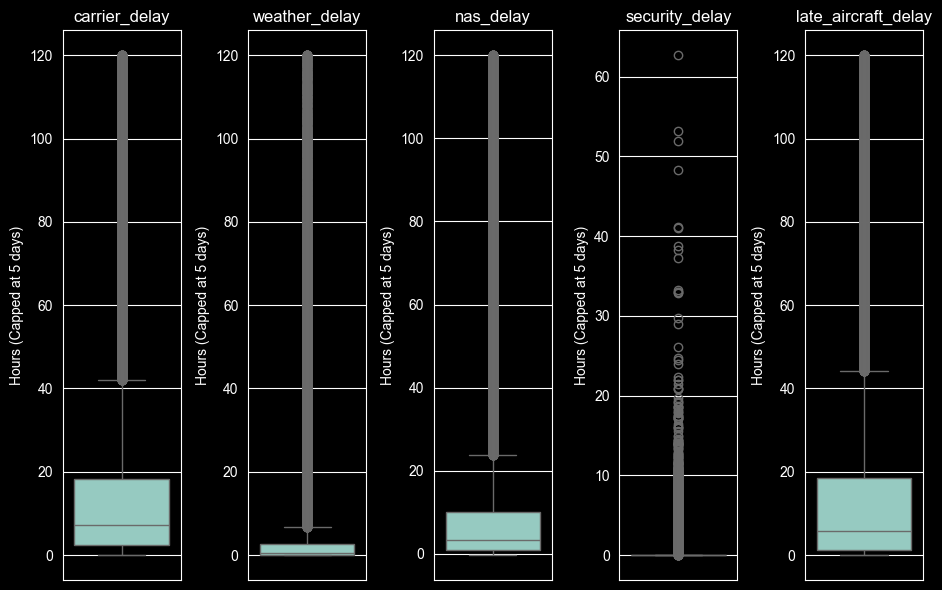

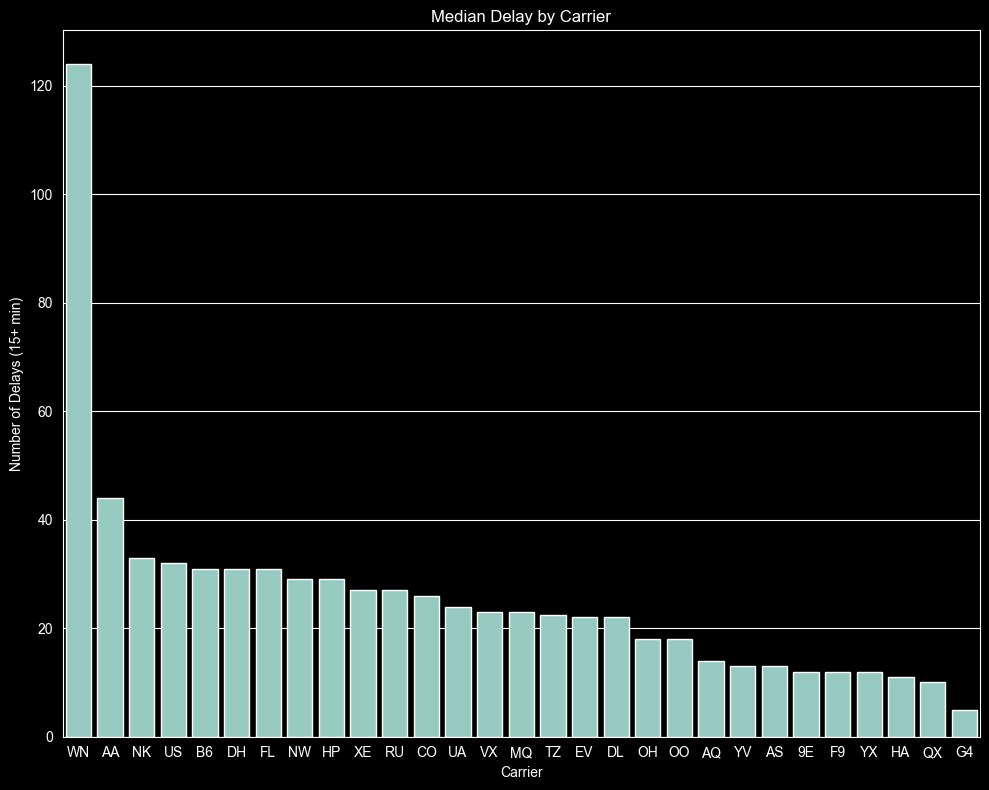

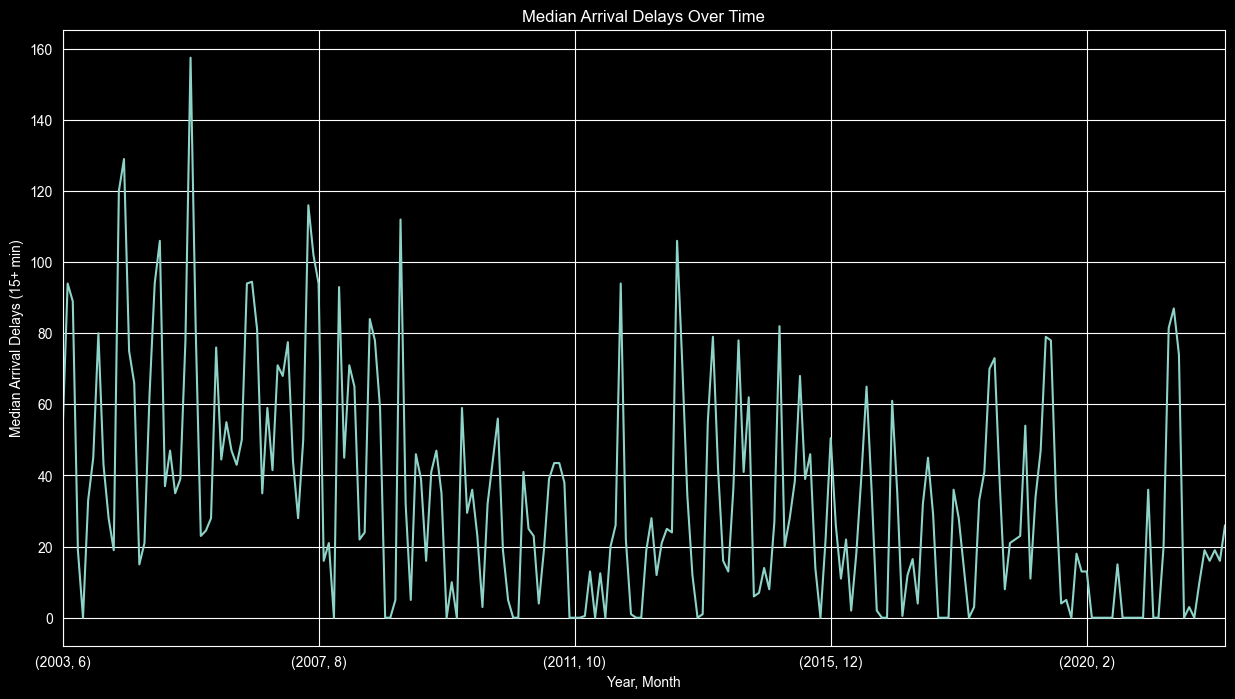

In [7]:
delay_var = [
    'carrier_delay',
    'weather_delay',
    'nas_delay',
    'security_delay',
    'late_aircraft_delay'
]

print(delays_df[delay_var].describe())

plt.figure(figsize=(15,6))

for i, col in enumerate(delay_var, 1):
    plt.subplot(1, 8, i)
    sns.boxplot(y=delays_df[col].clip(upper=7200) / 60)
    plt.title(col)
    plt.ylabel('Hours (Capped at 5 days)')
plt.tight_layout()
plt.show()
carrier_delays = delays_df.groupby('carrier')['arr_del15'].median().sort_values(ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x=carrier_delays.index, y=carrier_delays.values)
plt.xlabel("Carrier")
plt.ylabel("Number of Delays (15+ min)")
plt.title("Median Delay by Carrier")
plt.tight_layout()
plt.show()
monthly_delays = delays_df.groupby(['year', 'month'])['weather_delay'].median()

monthly_delays.plot(figsize=(15,8))
plt.xlabel("Year, Month")
plt.ylabel("Median Arrival Delays (15+ min)")
plt.title("Median Arrival Delays Over Time")
plt.margins(x=0)
plt.show()